In [1]:
import numpy as np
from scipy import signal
import soundfile as sf
import IPython.display
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt

In [2]:
#Calculate parameters using Thiele-Small Parameters
def calc_params(Vas, Vb, fb, fs):
    alpha = Vas/Vb 
    h = fb/fs
    return alpha, h

In [3]:
#trial calculation using other values
alpha, h = calc_params(0.062, 0.5, 78.66, 81)
print(alpha, h)

0.124 0.971111111111111


In [4]:
#define the transfer function coefficients 
def compute_coefficients(Ql, h, Qts, alpha):
    a1 = 1/(Ql*(np.sqrt(h))) + (np.sqrt(h))/Qts
    a2 = (alpha + 1)/h + h + 1/(Ql*Qts)
    a3 = 1/(Qts*(np.sqrt(h))) + (np.sqrt(h))/Ql
    return a1, a2, a3

In [5]:
import numpy as np
from scipy import signal

def vented_loudspeaker_filter(omega, a1, a2, a3, fs):
    #pre-warp frequency
    omega = 2 * np.pi * omega
    omega_prewarped = 2*fs*np.tan(omega/(2*fs))

    # Transfer function coefficients
    b = [1/(omega_prewarped**4), 0, 0, 0, 0]  # Numerator coefficients
    a = [1/(omega_prewarped**4), a3/(omega_prewarped**3), a2/(omega_prewarped**2), a1/omega_prewarped, 1]  # Denominator coefficients
    
    # Create the digital filter
    Bz, Az = signal.bilinear(b, a, fs)
    
    return Bz, Az

In [6]:
alpha = 2.32 
h = 1.33
fb = 30
Qts = 0.29
Ql = 7
fs = 44100
omega = 30
a1, a2, a3 = compute_coefficients(Ql, h, Qts, alpha)

In [7]:
Bz, Az = vented_loudspeaker_filter(omega, a1, a2, a3, fs)

In [7]:
t = np.arange(0, 1, 1/44100)
sin_wave = audio_signal = np.sin(2 * np.pi * 3000 * t) 
from IPython.display import Audio
Audio(sin_wave, rate = 44100)

In [8]:
speaker_response = signal.lfilter(Bz, Az, audio_signal)

In [9]:
Audio(speaker_response, rate = 44100)

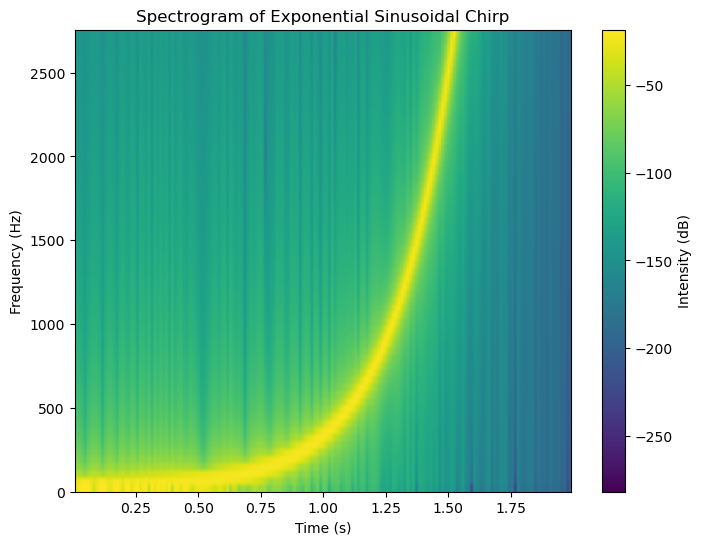

In [8]:
def logChirp(f0, f1, T, fs):
    '''
    outputs a chip that goes from frequency f0 to frequency f1 in T seconds
    with an exponential trajectory and with samplerate fs
    '''
    t = np.arange(0, T, 1.0/fs)
    k = np.log(f1/f0) / T
    s = np.sin(2 * np.pi * f0 * (np.exp(k * t) - 1) / k)

    return s

def plot_spectrogram(s, fs):
    plt.figure(figsize=(8, 6))
    plt.specgram(s, Fs=fs, NFFT=1024, noverlap=512, cmap='viridis')
    plt.colorbar(label='Intensity (dB)')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Spectrogram of Exponential Sinusoidal Chirp')
    plt.ylim(0, fs/16) 
    plt.show()


f0 = 5  
f1 = 20000
T = 2
fs = 44100 
chirp = logChirp(f0, f1, T, fs)

plot_spectrogram(chirp, fs)

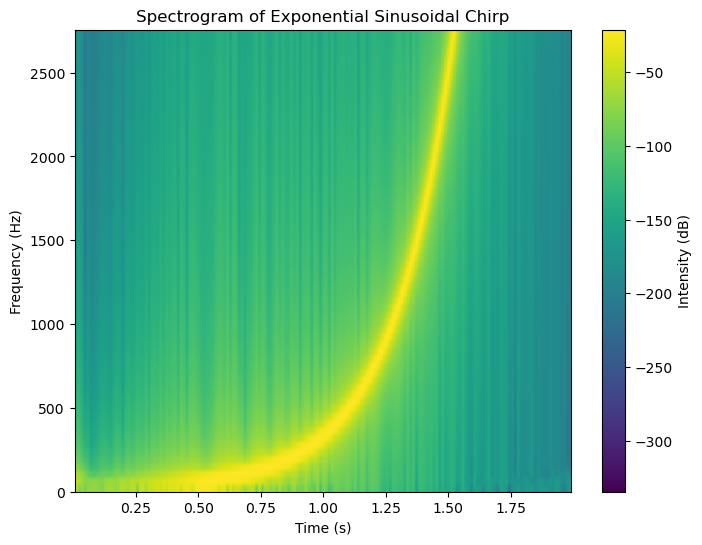

In [9]:
speaker_response = signal.lfilter(Bz, Az, chirp)
plot_spectrogram(speaker_response, fs)

In [10]:
Audio(chirp, rate = 44100)

In [11]:
Audio(speaker_response, rate = 44100)

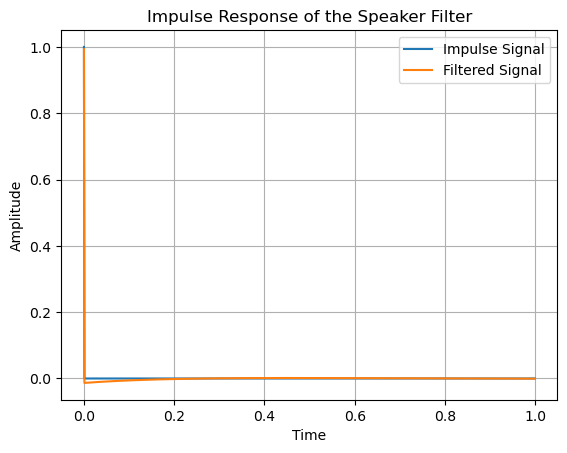

In [15]:
t = np.linspace(0, 1, 1000, endpoint=False)
impulse = np.zeros_like(t)
impulse[0] = 1

# Apply the filter to the impulse signal
filtered_impulse = signal.lfilter(Bz, Az, impulse)

# Plot the impulse signal and the filtered signal
plt.figure()
plt.plot(t, impulse, label='Impulse Signal')
plt.plot(t, filtered_impulse, label='Filtered Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Impulse Response of the Speaker Filter')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
guitar, fs = sf.read(r"C:\Users\Devyani Hebbar\Downloads\MPATE2607_hw6\MPATE2607_hw6\audio\gtr.wav")
Audio(guitar, rate = 44100)

In [17]:
speaker_guitar = signal.lfilter(Bz, Az, guitar)
Audio(speaker_guitar, rate = 44100)

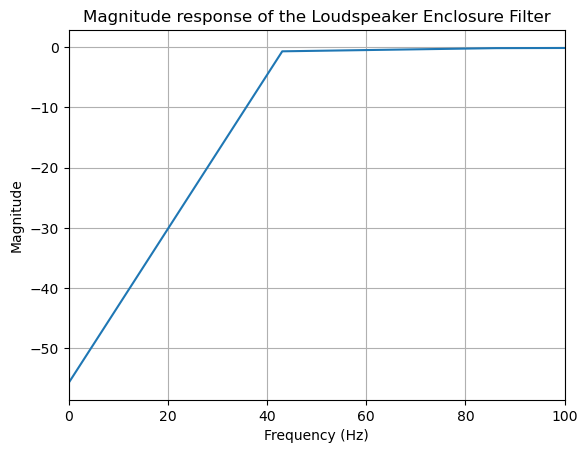

In [18]:
w, h = signal.freqz(Bz, Az)
freq_hz = w * (fs / (2 * np.pi))
plt.figure()
plt.plot(freq_hz, 10*np.log10(abs(h)))
plt.title('Magnitude response of the Loudspeaker Enclosure Filter')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 100)
plt.grid()
plt.show()

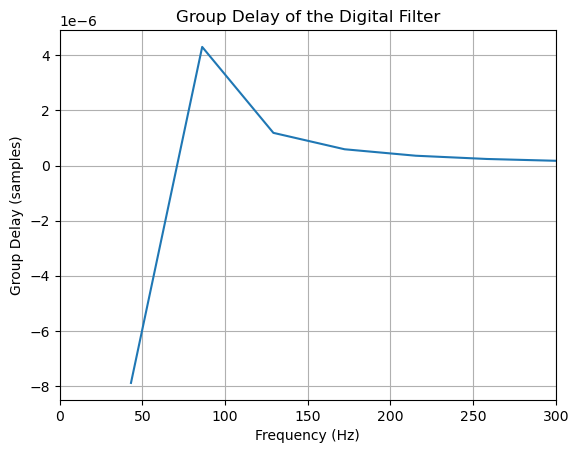

In [19]:
# Frequency response of the filter
w, h = signal.freqz(Bz, Az)

freq_hz = w * (fs / (2 * np.pi))

unwrapped_phase = np.unwrap(np.angle(h))

# Calculate the group delay
group_delay = -np.diff(unwrapped_phase) /(np.diff(freq_hz)* (fs / (2 * np.pi)))

# Plot the group delay
plt.plot(freq_hz[1:], group_delay)
plt.title('Group Delay of the Digital Filter')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Group Delay (samples)')
plt.xlim(0,300)
plt.grid()
plt.show()

In [20]:
#ALL PASS FILTER

class AllpassFilter:
    def __init__(self, w0, r):
        self.w0 = w0
        self.r = r
        self.z1 = 0
        self.z2 = 0
    
    def process_sample(self, x):
        y = (1 - (1/self.r) * np.exp(1j * self.w0) * self.z1) * x + (1 + (1/self.r) * np.exp(-1j * self.w0) * self.z1) - self.r * (np.exp(-1j * self.w0) * self.z2)
        self.z2 = self.z1
        self.z1 = y
        return y

In [21]:
def time_reverse(signal):
    return signal[::-1]

In [23]:
#define pole frequency and pole radius
w0 = 2*np.pi*(30/44100)
w0 = 2*fs*np.tan(w0/(2*fs))
r = 0.9968
N = fs*len(speaker_guitar )

In [24]:
allpass_filter = AllpassFilter(w0, r)

# Simulate processing of the signal
input_signal = speaker_guitar  
output_signal = np.zeros_like(input_signal)

# First LIFO buffer (time reversal)
buffered_signal = time_reverse(input_signal)

# Apply allpass filter
for i in range(len(buffered_signal)):
    output_signal[i] = allpass_filter.process_sample(buffered_signal[i])

# Second LIFO buffer (time reversal)
output_signal_reversed = time_reverse(output_signal)

C:\conda_tmp\ipykernel_21520\2294992996.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  output_signal[i] = allpass_filter.process_sample(buffered_signal[i])


In [25]:
Audio(output_signal_reversed, rate = fs)

In [26]:
def compute_frequency_response(allpass_filter, num_points=1000):
    frequencies = np.linspace(0, np.pi, num_points)
    response = np.zeros_like(frequencies, dtype=np.complex128)
    for i, freq in enumerate(frequencies):
        z = np.exp(1j * freq)
        numerator = (1 - (1/allpass_filter.r) * np.exp(1j * allpass_filter.w0) * z**(-1)) * (1 + (1/allpass_filter.r) * np.exp(-1j * allpass_filter.w0) * z**(-1))
        denominator = (1 - allpass_filter.r * np.exp(-1j * allpass_filter.w0) * z**(-1)) * (1 + allpass_filter.r * np.exp(1j * allpass_filter.w0) * z**(-1))
        response[i] = numerator / denominator
    return frequencies, response

In [27]:
def plot_group_delay(frequencies, response):
    phase_response = np.angle(response)
    group_delay = -np.diff(phase_response) / np.diff(frequencies)
    plt.plot(frequencies[:-1], group_delay)
    plt.title('Group Delay Response')
    plt.xlabel('Frequency (radians/sample)')
    plt.ylabel('Group Delay (samples)')
    plt.grid()
    plt.show()

def plot_magnitude_response(frequencies, response):
    magnitude_response = np.abs(response)
    plt.plot(frequencies, magnitude_response)
    plt.title('Magnitude Response')
    plt.xlabel('Frequency (radians/sample)')
    plt.ylabel('Magnitude')
    plt.grid()
    plt.show()

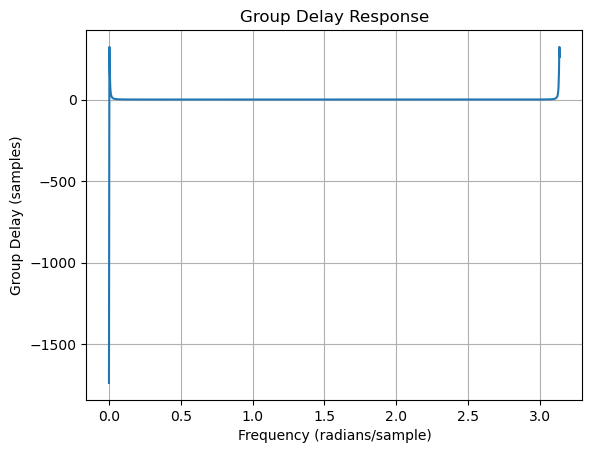

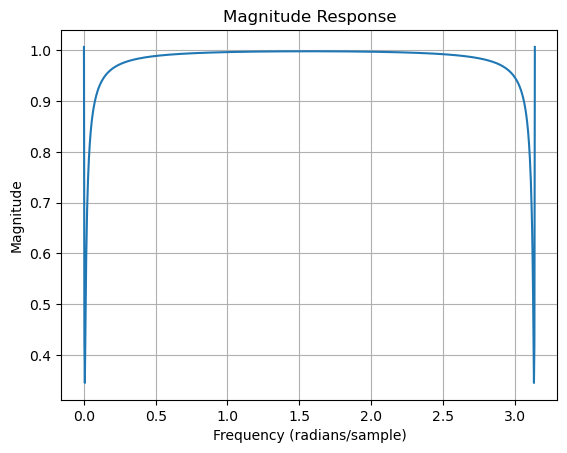

In [28]:
allpass_filter = AllpassFilter(w0, r)

# Compute frequency response
frequencies, response = compute_frequency_response(allpass_filter)

# Plot group delay response
plot_group_delay(frequencies, (response))

# Plot magnitude response
plot_magnitude_response(frequencies, (response))

C:\Users\Devyani Hebbar\anaconda3_3.0\Lib\site-packages\matplotlib\axes\_axes.py:7774: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


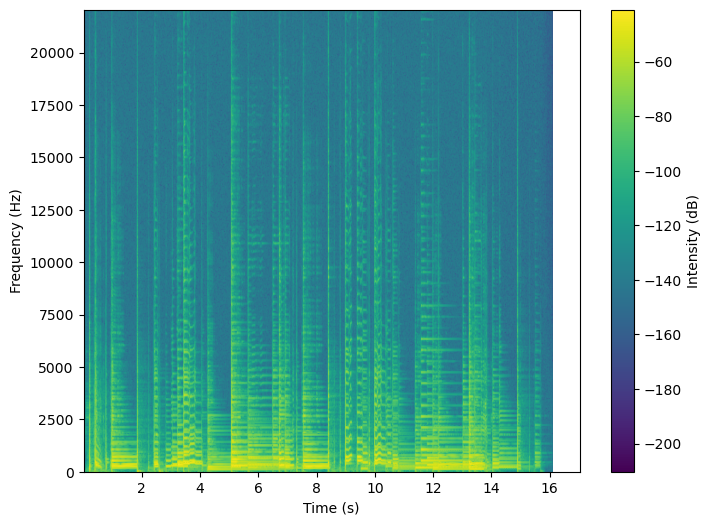

In [29]:
plt.figure(figsize=(8, 6))
plt.specgram(guitar, Fs=fs, NFFT=1024, noverlap=512, cmap='viridis')
plt.colorbar(label='Intensity (dB)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim(0, fs/2) 
plt.show()

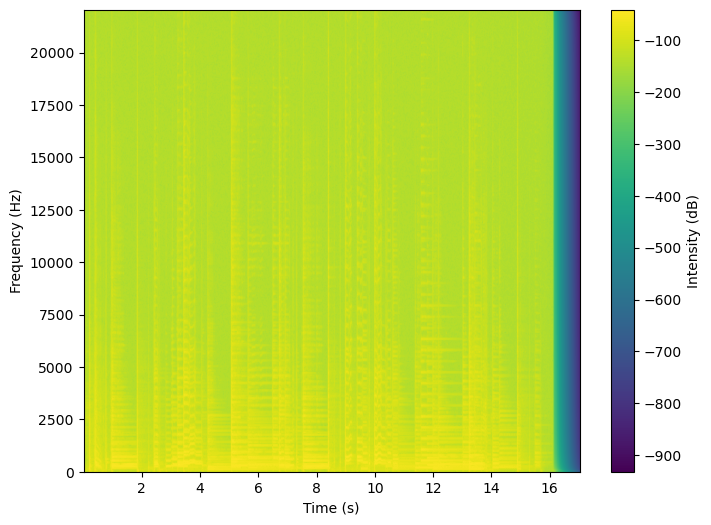

In [30]:
plt.figure(figsize=(8, 6))
plt.specgram(speaker_guitar, Fs=fs, NFFT=1024, noverlap=512, cmap='viridis')
plt.colorbar(label='Intensity (dB)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim(0, fs/2) 
plt.show()

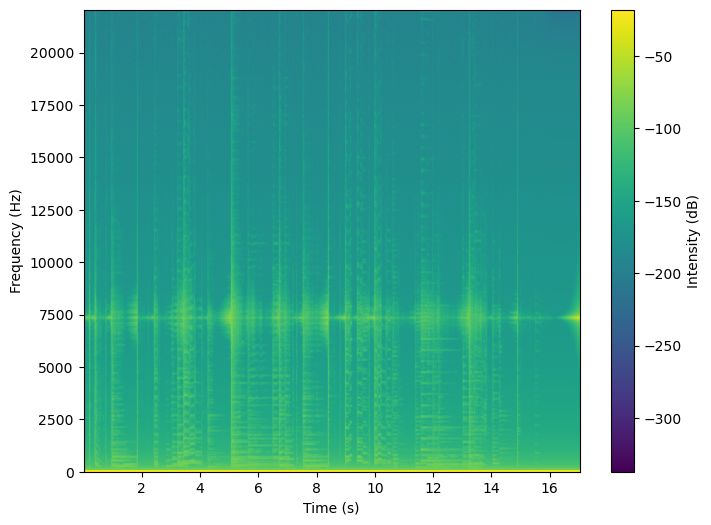

In [31]:
plt.figure(figsize=(8, 6))
plt.specgram(output_signal_reversed, Fs=fs, NFFT=1024, noverlap=512, cmap='viridis')
plt.colorbar(label='Intensity (dB)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim(0, fs/2) 
plt.show()